In [1]:
pwd

'C:\\Users\\Andrey\\Downloads'

In [2]:
cd DataForOCR/

C:\Users\Andrey\Downloads\DataForOCR


In [48]:
!dir /B > text.txt

In [49]:
f = open('text.txt', 'r')
files = f.read()
f.close()

files = files.split()
print(files)

['0.jpeg', '1.jpeg', '2.jpeg', '3.jpeg', '4.jpeg', '5.jpeg', '6.jpeg', '7.jpeg', '8.jpeg', '9.jpeg', 'arial.ttf', 'craft_mlt_25k.pth', 'cyrillic_g2.pth', 'frozen_east_text_detection.pb', 'text.txt']


In [52]:
images = [image for image in files if '.jpeg' in image]
print(images)

['0.jpeg', '1.jpeg', '2.jpeg', '3.jpeg', '4.jpeg', '5.jpeg', '6.jpeg', '7.jpeg', '8.jpeg', '9.jpeg']


In [3]:
# !pip install easyocr

In [53]:
import easyocr
# show an image
import PIL
from PIL import ImageDraw
from PIL import Image, ImageDraw, ImageFont
import numpy as np

In [54]:
font = ImageFont.truetype("arial.ttf",18)

image_1 = images[0]
image_2 = images[1]
first_image = Image.open(image_1)

second_image = Image.open(image_2)

## Easy OCR

In [55]:
def draw_boxes(image, bounds, width=2, text=False):
    draw = ImageDraw.Draw(image)
    for bound in bounds:
        p0, p1, p2, p3 = bound[0]
        draw.line([*p0, *p1, *p2, *p3, *p0], fill='red', width=width) # random colors to better see
        if text:
            w, h = font.getsize(bound[1])
            x, y = p0[0]-10, p0[1]-10
            c = np.random.randint(100)+155
            draw.rectangle((x, y, x + w, y + h), fill=(c,c,c))
            draw.text([x,y],bound[1],fill='blue',font=font,stroke_fill='white',)

    return image

In [56]:
# Create a reader to do OCR.
# If you change to GPU instance, it will be faster. But CPU is enough.
# (by MENU > Runtime > Change runtime type > GPU, then redo from beginning )

reader = easyocr.Reader(['en', 'ru'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [57]:
# easy OCR

first = reader.readtext(image_1)

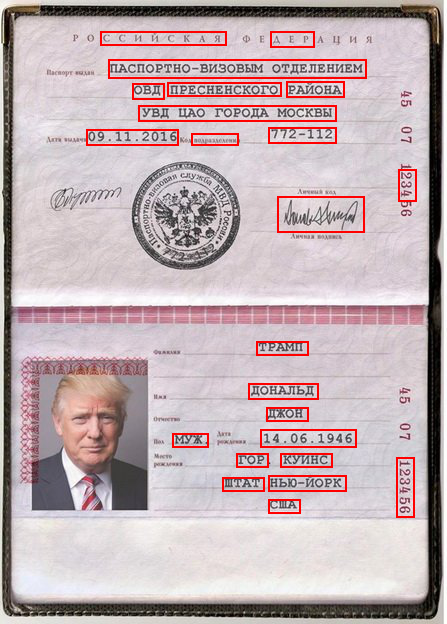

In [58]:
# Draw bounding boxes
draw_boxes(first_image, first)

In [59]:
# Draw book results

[i[1] for i in first]

['C с и и с к ; я',
 '4 Е ₽',
 'ПАСПОРТНО-визовым ОтДЕЛЕНИЕМ',
 'овд',
 'ПРЕСНЕНСКОГО',
 'РАЙОНА',
 'УВД ЦАО ГОРОДА МОСКВЫ',
 '09.11.2016',
 'аарачагыы',
 '772-112',
 '&',
 'NwWlwn',
 'ТРАМП',
 'ДОНАЛЬД',
 'Джон',
 'Муж',
 '14 . 06 . 1946',
 'ГОР',
 'КУИНС',
 'ШТАТ',
 'НЬЮ-ЙОРК',
 'g',
 'США']

C:\Users\Andrey\AppData\Local\Temp\ipykernel_1420\576043199.py:7: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  w, h = font.getsize(bound[1])


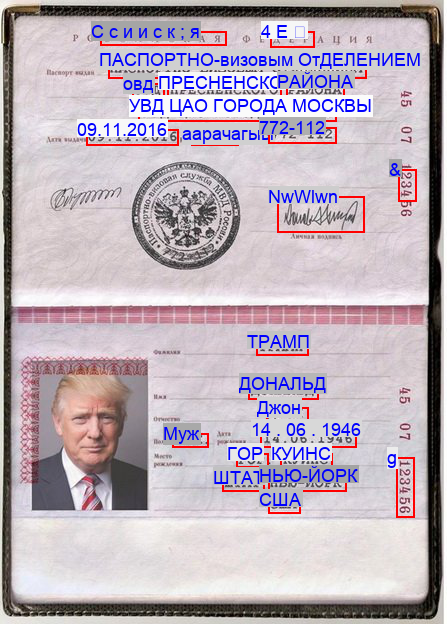

In [60]:
# Draw bounding boxes

draw_boxes(first_image, first,text=True)

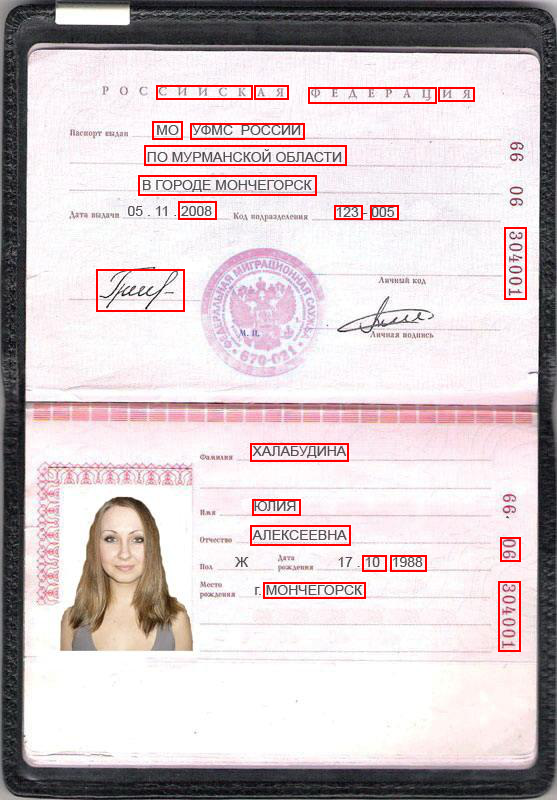

In [61]:
# Draw bounding boxes
second = reader.readtext(image_2, width_ths=0.5, 
                        y_ths=0.5, text_threshold=0.7, 
                         paragraph=False)

draw_boxes(second_image, second)

In [62]:
# Draw book results
second = reader.readtext(image_2, width_ths=0.5, 
                        y_ths=0.5, text_threshold=0.7, 
                         paragraph=False, rotation_info=[90, 180 ,270], detail=0)
" ".join(second)

'€ Ии € к 4 Я Ф Е4 ₽ ₽ А ц 1 и 6 1 1 1 2008 123 005 304001 Х ХАЛАБУДИНА ЮЛИЯ АЛЕКСЕЕВНА 06 10 1988 304001 МОНЧЕГОРСК'

## Tesseract

In [63]:
# !pip install pytesseract

In [64]:
import pytesseract
import shutil
import os
import random

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
print(pytesseract.get_languages(config=''))

['eng', 'enm', 'osd', 'rus']


In [65]:
extractedInformation = pytesseract.image_to_string(Image.open(image_2), lang='rus')
print(extractedInformation)

МО УФМС РОССИИ
ПО МУРМАНСКОЙ ОБЛАСТИ

В ГОРОДЕ МОНЧЕГОРСК
О ИВ Пе 1505

ХАЛАБУДИНА.

юлия
АЛЕКСЕЕВНА
17.10.1988
„„__ Г МОНЧЕГОРСК




In [66]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt

class Extract:
    def __init__(self, image):
        self.__image = image
        self.__data = None
        
    def extract_data(self):
        df = pd.DataFrame([x.split('\t') for x in pytesseract.image_to_data(Image.open(self.__image), lang='rus') \
                              .split('\n')])

        df = df.rename(columns=df.iloc[0]) \
                        .drop(df.index[0]) \
                        .replace('', np.nan) \
                        .dropna(subset=['text'])

        df.set_index(pd.Index(list(range(df.shape[0]))), inplace=True)
        df = df[df.columns[6:]]
        df[df.columns[:4]] = df[df.columns[:4]].astype('int32')
        self.__data = df.copy()
        return self.__data


    def show_image(self):
        assert self.__data is not None, "Примените функцию 'extract_data' для извлечения данных"
        image = cv2.imread(self.__image, cv2.IMREAD_COLOR)
        b, g, r = cv2.split(image) # img b,g,r
        image = cv2.merge([r,g,b])

        for i in range(self.__data.shape[0]):
            left, top, width, height = self.__data.iloc[i, :4]
            image = cv2.rectangle(image, (left, top), (left+width, top+height), (255, 0, 0), 1)

        plt.figure(figsize=(10,10))
        plt.imshow(image)

In [67]:
ex = Extract(image_1)
data = ex.extract_data()
data.head()

,left,top,width,height,conf,text
0,73,35,147,7,23.933273,россиийскля
1,243,36,128,7,88.427887,ФЕДЕРАЦИЯ
2,110,64,153,9,89.464180,ПАСПОРТНО-ВИЗОВЫМ
3,272,64,90,10,96.091614,ОТДЕЛЕНИЕМ
4,134,85,26,11,84.367744,ОВД


In [68]:
" ".join(data.text)

'россиийскля ФЕДЕРАЦИЯ ПАСПОРТНО-ВИЗОВЫМ ОТДЕЛЕНИЕМ ОВД ПРЕСНЕНСКОГО РАЙОНА УВД ЦАО ГОРОДА МОСКВЫ -09.11.201бънины 772-112 ПИ Е же НЕ жи аа СЕ ЕЕ Е ЕЕ ТРАМП ДОНАЛЬД джон :.. 14.06.1946 ГОР. КУИНС ШТАТ НЬЮ-ЙОРК сил.  '

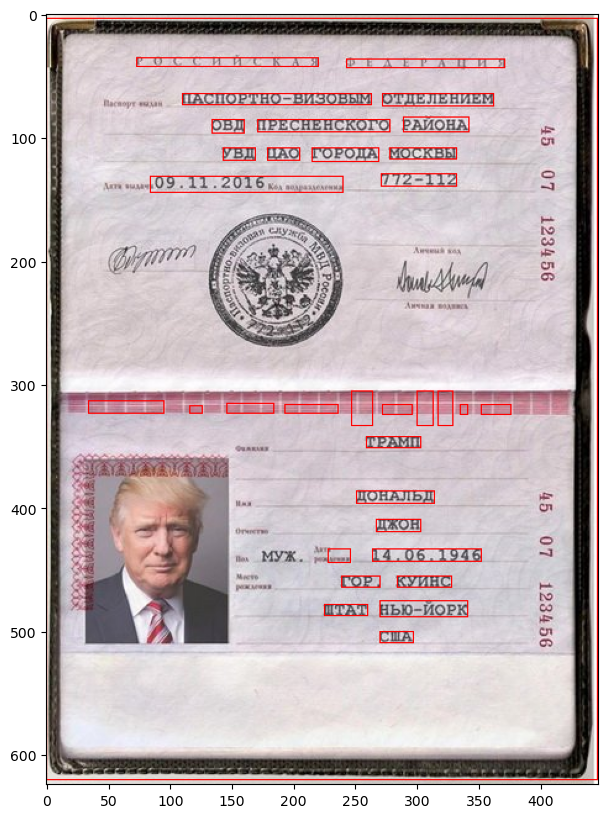

In [69]:
ex.show_image()

In [70]:
ex = Extract(image_2)
data = ex.extract_data()
data.head()

,left,top,width,height,conf,text
0,157,125,21,10,93.127502,МО
1,193,125,39,10,93.127502,УФМС
2,242,125,58,10,96.035782,РОССИИ
3,148,152,19,10,94.495316,ПО
4,173,149,98,13,94.495316,МУРМАНСКОЙ


In [71]:
" ".join(data.text)

'МО УФМС РОССИИ ПО МУРМАНСКОЙ ОБЛАСТИ В ГОРОДЕ МОНЧЕГОРСК О ИВ Пе 1505 ХАЛАБУДИНА. юлия АЛЕКСЕЕВНА 17.10.1988 „„__ Г МОНЧЕГОРСК  '

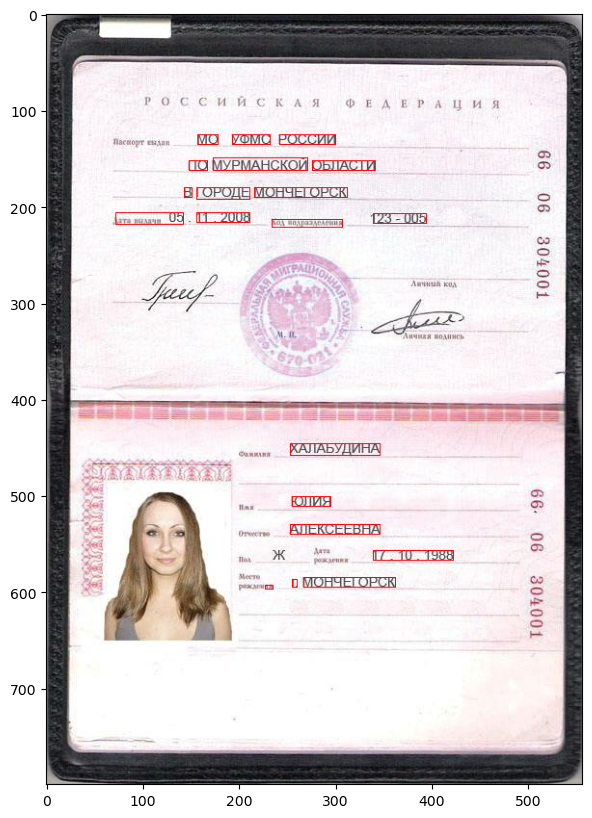

In [72]:
ex.show_image()